In [ ]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [1]:
import os

import altair as alt
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import teotil3 as teo
from pygeos import GEOSException

alt.data_transformers.disable_max_rows()
plt.style.use("ggplot")

# Task 2.1: Update TEOTIL "core" datasets

## Part B: Summarise and combine regine-level data

From the proposal text:

> **Oppgave 2.1: Oppdatere og forbedre kjernedatasett**
> 
> Følgende datasett vil bli oppdatert:
>  * Nedbørfeltsgrenser (reginefelt fra NVE)
>  * Innsjødatabase og innsjødyp (fra NVE)
>  * Elvenett (ELVIS og Hovedelv-segmenter fra NVE)
>  * Arealbruk (AR50 fra NIBIO)
>  * Atmosfærisk avsetning av N (fra NILU)
>  * Administrative grenser (fylker og kommuner fra Geonorge)
>  
> Reginefeltene vil bli brukt til å oppsummere de andre datasettene, for eksempel ved å beregne arealbruksstatistikk og gjennomsnittlig atmosfærisk deponering for hvert reginefelt og ved å skjære fylke- og kommunegrensene. Så langt det er mulig vil arbeidsflyten være skriptet for å gjøre den repeterbar og enklere å vedlikeholde ettersom datasett oppdateres i fremtiden (selv om noe manuelt arbeid fortsatt vil være nødvendig).

## 1. Download the latest datasets

As of 2022, most datasets can be downloaded in **FGDB format**, which is cleaner and more efficient than using shapefiles. The exception is the administrative boundaries, some of which are only available in SOSI format. These therefore need processing first - see notebook `T2-1a`. All datasets are available in **ETRS89-based UTM Zone 33N**.

The following datasets can be downloaded from NVE [here](http://nedlasting.nve.no/gis/):

 * Elv
    - Hovedelv
    - Elvenett
 * Innsjø
    - Innsjø
    - Dybdedata - innsjø
 * Nedbørfelt
    - Vassdragsområder
    - Nedbørfelt til hav
    - Sidenedbørfelt
    - Regine enhet
 * Vanndirektivet
    - Select all options

Administrative boundaries can be downloaded from [Geonorge](https://www.geonorge.no/):

 * Administrative enheter fylker
 * Administrative enheter kommuner
 * Administrative enheter - historiske versjoner (for years before 2022)
 
Land cover can be downloaded from [NIBIO's Kilden](https://kart8.nibio.no/nedlasting/dashboard):

 * Arealressurskart - AR50


**All datasets were downloaded during June 2022 and added to `shared/teotil3/core_data_june_2022` on JupyterHub**.

In [2]:
# Set periods of interest for fylke and kommune boundaries
admin_years = range(2014, 2024)

In [3]:
# Get input file paths
data_fold = f"/home/jovyan/shared/common/teotil3/core_data"
nve_gdb = os.path.join(data_fold, "hydrology", "NVEData.gdb")
ar50_gdb = os.path.join(data_fold, "land_cover", "nibio_ar50.gdb")
ro_grid_path = r"/home/jovyan/shared/common/teotil3/nve_hbv_data/runoff_1991-2020_mm_year.tif"
admin_gpkg = os.path.join(
    data_fold, "administrative", "admin_data.gpkg"
)  # Created by notebook T2-1a

# Output paths
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
reg_csv = os.path.join(data_fold, "tidied", f"regines.csv")

## 1. Read regine polygons

In [4]:
reg_gdf = teo.preprocessing.read_raw_regine_data(nve_gdb, "RegineEnhet")
reg_gdf.head()

regine vassom  a_cat_poly_km2  upstr_a_km2  \
0    001.10    001        1.442790         0.00   
1   001.1A1    001        1.432479       777.90   
2  001.1A20    001        0.340160       777.90   
3  001.1A2A    001       17.647822        58.96   
4  001.1A2B    001       41.298255        41.30   

                                            geometry  
0  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4  MULTIPOLYGON (((303353.460 6552989.330, 303341...

## 2. Assign regines to fylker, kommuner and OSPAR regions

Each regine is assigned to a single fylke, kommune and OSPAR region. For regines overlapping several fylker/kommuner, the fylke/kommune with the largest proportion of the regine by area is chosen. 

**Note:** NVE's regine dataset extends beyond Norway to cover whole catchments, whereas the fylke and kommune datasets stop at the border. Some regines are therefore entirely beyond the edge of the administrative data, or have only a tiny fraction of their total area within Norway. For regines with no overlapping fylke or kommune, I have assigned `fylnr = komnr = -1`.

The code below attempts to process administrative boundaries for all years, but some years are skipped due to SOSI issues (possibly related to [this](https://github.com/shapely/shapely/issues/1364) GEOS problem). For future processing of single years, just set `admin_years` to be a single-element list. This should then extend the data in `admin_gpkg`.

In [5]:
%%time

# Assign OSPAR regions
reg_gdf = teo.preprocessing.assign_regines_to_ospar_regions(reg_gdf)

# Assign administrative regions
for admin_year in admin_years:
    print("####################################################################")
    print(f"Processing {admin_year}...")
    try:
        reg_gdf = teo.preprocessing.assign_regines_to_administrative_units(
            reg_gdf, admin_gpkg, admin_year
        )
        reg_gdf.rename(
            {"komnr": f"komnr_{admin_year}", "fylnr": f"fylnr_{admin_year}"},
            axis="columns",
            inplace=True,
        )
    except GEOSException:
        print("WARNING:", admin_year, "is affected by a problem with GEOS.")

reg_gdf.head()

####################################################################
Processing 2014...
Processing kommuner
    428 kommuner.
    23796 regines.
    31953 intersected polygons.
    23513 regines assigned to kommuner.
Processing fylker
    19 kommuner.
    23796 regines.
    25032 intersected polygons.
    23513 regines assigned to fylker.
####################################################################
Processing 2015...
Processing kommuner
    428 kommuner.
    23796 regines.
    31948 intersected polygons.
    23513 regines assigned to kommuner.
Processing fylker
    19 kommuner.
    23796 regines.
    25032 intersected polygons.
    23513 regines assigned to fylker.
####################################################################
Processing 2016...
Processing kommuner
    428 kommuner.
    23796 regines.
    31951 intersected polygons.
    23513 regines assigned to kommuner.
Processing fylker
    19 kommuner.
    23796 regines.
    25032 intersected polygons.
    23513 regin

regine vassom  a_cat_poly_km2  upstr_a_km2 ospar_region komnr_2014  \
0    001.10    001        1.442790         0.00    Skagerrak       0101   
1   001.1A1    001        1.432479       777.90    Skagerrak       0101   
2  001.1A20    001        0.340160       777.90    Skagerrak       0101   
3  001.1A2A    001       17.647822        58.96    Skagerrak       0101   
4  001.1A2B    001       41.298255        41.30    Skagerrak       0101   

  fylnr_2014 komnr_2015 fylnr_2015 komnr_2016  ... fylnr_2019 komnr_2020  \
0         01       0101         01       0101  ...         01       3001   
1         01       0101         01       0101  ...         01       3001   
2         01       0101         01       0101  ...         01       3001   
3         01       0101         01       0101  ...         01       3001   
4         01       0101         01       0101  ...         01       3001   

  fylnr_2020 komnr_2021 fylnr_2021 komnr_2022 fylnr_2022 komnr_2023  \
0         30       3001         30       3001         30       3001   
1         30       3001         30       3001         30       3001   
2         30       3001         30       3001         30       3001   
3         30       3001         30       3001         30       3001   
4         30       3001         30       3001         30       3001   

  fylnr_2023                                           geometry  
0         30  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1         30  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2         30  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3         30  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4         30  MULTIPOLYGON (((303353.460 6552989.330, 303341...  

[5 rows x 26 columns]

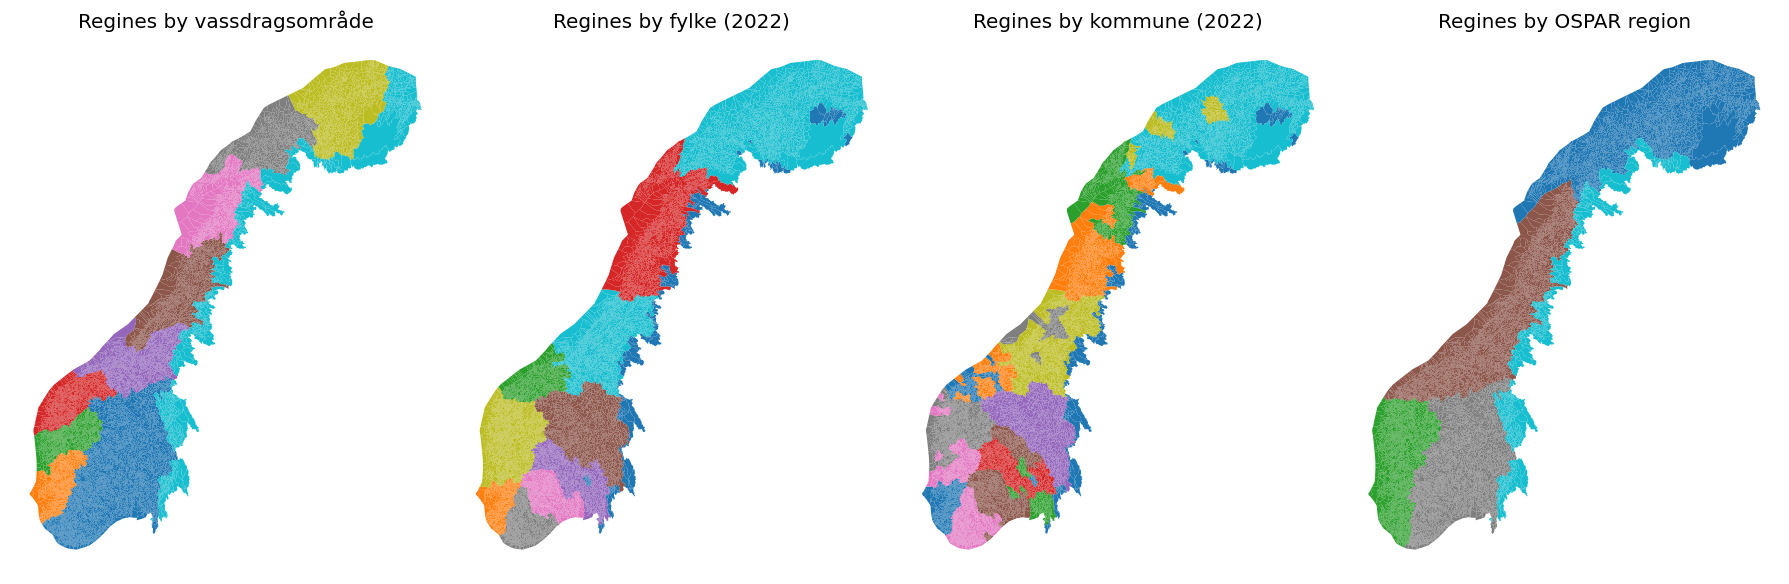

In [6]:
admin_year_plot = 2022

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
reg_gdf.plot(column="vassom", categorical=True, ax=axes[0])
reg_gdf.plot(column=f"fylnr_{admin_year_plot}", categorical=True, ax=axes[1])
reg_gdf.plot(column=f"komnr_{admin_year_plot}", categorical=True, ax=axes[2])
reg_gdf.plot(column="ospar_region", categorical=True, ax=axes[3])
axes[0].set_title("Regines by vassdragsområde")
axes[1].set_title(f"Regines by fylke ({admin_year_plot})")
axes[2].set_title(f"Regines by kommune ({admin_year_plot})")
axes[3].set_title("Regines by OSPAR region")
for ax in axes:
    ax.set_axis_off()
plt.tight_layout()

## 3. Land cover proportions

TEOTIL currently considers the following broad land cover classes:

 * Urban
 * Woodland
 * Agricultural
 * Upland
 * Glacier
 * Sea
 * Lake

**Note:** As above, some regines lie entirely outside of Norway and are therefore not covered by AR50. I have classed these as 100% "other/not mapped" (`artype = 99`) in the code below.

In [7]:
%%time

ar50_gdf = gpd.read_file(ar50_gdb, driver="fileGDB", layer="org_ar_ar50_flate")
reg_gdf = teo.preprocessing.calculate_ar50_land_cover_proportions(reg_gdf, ar50_gdf)
reg_gdf.head()

Reclassifying...
Reprojecting to equal area...
Intersecting polygons...
Aggregating...
CPU times: user 24min 6s, sys: 45.3 s, total: 24min 52s
Wall time: 24min 52s


regine vassom  a_cat_poly_km2  upstr_a_km2 ospar_region komnr_2014  \
0    001.10    001        1.442790         0.00    Skagerrak       0101   
1   001.1A1    001        1.432479       777.90    Skagerrak       0101   
2  001.1A20    001        0.340160       777.90    Skagerrak       0101   
3  001.1A2A    001       17.647822        58.96    Skagerrak       0101   
4  001.1A2B    001       41.298255        41.30    Skagerrak       0101   

  fylnr_2014 komnr_2015 fylnr_2015 komnr_2016  ... a_glacier_km2 a_lake_km2  \
0         01       0101         01       0101  ...           0.0   0.000013   
1         01       0101         01       0101  ...           0.0   0.048098   
2         01       0101         01       0101  ...           0.0   0.036623   
3         01       0101         01       0101  ...           0.0   0.122567   
4         01       0101         01       0101  ...           0.0   7.513687   

    a_other_km2 a_sea_km2 a_upland_km2 a_urban_km2 a_wood_km2 ar50_tot_a_km2  \
0  3.116485e-01  0.281940     0.000000    0.000000   0.849188       0.849201   
1  2.223036e-03  0.000067     0.004615    0.000000   1.377476       1.430189   
2  0.000000e+00  0.000045     0.000000    0.000000   0.303492       0.340114   
3  0.000000e+00  0.000000     0.467374    0.131585  15.030746      17.647822   
4  1.563194e-13  0.000000     2.250799    0.161524  29.798394      41.298255   

  a_cat_land_km2                                           geometry  
0       1.160850  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1       1.432412  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2       0.340114  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3      17.647822  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4      41.298255  MULTIPOLYGON (((303353.460 6552989.330, 303341...  

[5 rows x 36 columns]

## 4. NVE lake areas

For comparison with AR50, it seems sensible to summarise lake areas per regine from the NVE dataset as well.

**Note:** In many cases, especially in the far north of the country, areas identified as "lakes" by NVE are classed as "myr" in AR50 (`artype = 60`). I'm not sure how best to resolve this at present.

In [8]:
%%time

lake_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="Innsjo")
reg_gdf = teo.preprocessing.calculate_nve_regine_lake_areas(reg_gdf, lake_gdf)
reg_gdf.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1803: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


CPU times: user 2min 23s, sys: 362 ms, total: 2min 23s
Wall time: 2min 23s


regine vassom  a_cat_poly_km2  upstr_a_km2 ospar_region komnr_2014  \
0    001.10    001        1.442790         0.00    Skagerrak       0101   
1   001.1A1    001        1.432479       777.90    Skagerrak       0101   
2  001.1A20    001        0.340160       777.90    Skagerrak       0101   
3  001.1A2A    001       17.647822        58.96    Skagerrak       0101   
4  001.1A2B    001       41.298255        41.30    Skagerrak       0101   

  fylnr_2014 komnr_2015 fylnr_2015 komnr_2016  ... a_lake_km2   a_other_km2  \
0         01       0101         01       0101  ...   0.000013  3.116485e-01   
1         01       0101         01       0101  ...   0.048098  2.223036e-03   
2         01       0101         01       0101  ...   0.036623  0.000000e+00   
3         01       0101         01       0101  ...   0.122567  0.000000e+00   
4         01       0101         01       0101  ...   7.513687  1.563194e-13   

  a_sea_km2 a_upland_km2 a_urban_km2 a_wood_km2 ar50_tot_a_km2 a_cat_land_km2  \
0  0.281940     0.000000    0.000000   0.849188       0.849201       1.160850   
1  0.000067     0.004615    0.000000   1.377476       1.430189       1.432412   
2  0.000045     0.000000    0.000000   0.303492       0.340114       0.340114   
3  0.000000     0.467374    0.131585  15.030746      17.647822      17.647822   
4  0.000000     2.250799    0.161524  29.798394      41.298255      41.298255   

  a_lake_nve_km2                                           geometry  
0       0.000000  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1       0.043955  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2       0.000000  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3       0.186340  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4       7.344123  MULTIPOLYGON (((303353.460 6552989.330, 303341...  

[5 rows x 37 columns]

## 5. Summarise hydrological characteristics

In [9]:
%%time

reg_gdf = teo.preprocessing.summarise_regine_hydrology(reg_gdf, ro_grid_path, all_touched=True)
reg_gdf.head()

CPU times: user 2min 22s, sys: 9.51 s, total: 2min 31s
Wall time: 2min 45s


regine vassom  a_cat_poly_km2  upstr_a_km2 ospar_region komnr_2014  \
0    001.10    001        1.442790         0.00    Skagerrak       0101   
1   001.1A1    001        1.432479       777.90    Skagerrak       0101   
2  001.1A20    001        0.340160       777.90    Skagerrak       0101   
3  001.1A2A    001       17.647822        58.96    Skagerrak       0101   
4  001.1A2B    001       41.298255        41.30    Skagerrak       0101   

  fylnr_2014 komnr_2015 fylnr_2015 komnr_2016  ... a_sea_km2 a_upland_km2  \
0         01       0101         01       0101  ...  0.281940     0.000000   
1         01       0101         01       0101  ...  0.000067     0.004615   
2         01       0101         01       0101  ...  0.000045     0.000000   
3         01       0101         01       0101  ...  0.000000     0.467374   
4         01       0101         01       0101  ...  0.000000     2.250799   

  a_urban_km2 a_wood_km2 ar50_tot_a_km2 a_cat_land_km2 a_lake_nve_km2  \
0    0.000000   0.849188       0.849201       1.160850       0.000000   
1    0.000000   1.377476       1.430189       1.432412       0.043955   
2    0.000000   0.303492       0.340114       0.340114       0.000000   
3    0.131585  15.030746      17.647822      17.647822       0.186340   
4    0.161524  29.798394      41.298255      41.298255       7.344123   

  runoff_mm/yr q_cat_m3/s                                           geometry  
0          602    0.02214  MULTIPOLYGON (((297006.830 6543966.950, 297169...  
1          620    0.02814  MULTIPOLYGON (((297505.440 6543157.790, 297543...  
2          594    0.00640  MULTIPOLYGON (((297770.368 6543429.036, 297787...  
3          637    0.35623  MULTIPOLYGON (((299678.370 6544460.320, 299667...  
4          637    0.83362  MULTIPOLYGON (((303353.460 6552989.330, 303341...  

[5 rows x 39 columns]

## 6. Save dataset

The final regine dataset can now be saved for use later.

In [10]:
# Round numeric columns to sensible precision
num_cols = list(reg_gdf.select_dtypes('number'))
for col in num_cols:
    if col.split('_')[-1] == 'km2':
        reg_gdf[col] = reg_gdf[col].round(6)
    elif col.split('_')[-1] == 'mm/yr':
        reg_gdf[col] = reg_gdf[col].round(0).astype(int)
    elif col.split('_')[-1] == 'm3/s':
        reg_gdf[col] = reg_gdf[col].round(6)
    else:
        pass

In [11]:
teo.io.geodataframe_to_geopackage(
    reg_gdf,
    teo_gpkg,
    f"regines",
    attrib_tab_csv=reg_csv,
)

## 7. Basic checking

In [12]:
# Read saved data
reg_gdf = gpd.read_file(teo_gpkg, layer=f"regines", driver="GPKG")

# Check for NaN
pd.isna(reg_gdf).sum(axis="rows")

regine            0
vassom            0
a_cat_poly_km2    0
upstr_a_km2       0
ospar_region      0
komnr_2014        0
fylnr_2014        0
komnr_2015        0
fylnr_2015        0
komnr_2016        0
fylnr_2016        0
komnr_2017        0
fylnr_2017        0
komnr_2018        0
fylnr_2018        0
komnr_2019        0
fylnr_2019        0
komnr_2020        0
fylnr_2020        0
komnr_2021        0
fylnr_2021        0
komnr_2022        0
fylnr_2022        0
komnr_2023        0
fylnr_2023        0
a_agri_km2        0
a_glacier_km2     0
a_lake_km2        0
a_other_km2       0
a_sea_km2         0
a_upland_km2      0
a_urban_km2       0
a_wood_km2        0
ar50_tot_a_km2    0
a_cat_land_km2    0
a_lake_nve_km2    0
runoff_mm/yr      0
q_cat_m3/s        0
geometry          0
dtype: int64

### 7.1. Compare NVE's regine areas to totals from AR50

`ar50_tot_a_km2` is defined as the sum of AR50 classes that are not `sea` or `other`. 

Note that most of the differences are along Norway's eastern border, where the regines extend into Sweden/Finland, but AR50 stops. This is why `a_cat_land_km2` is always larger than `ar50_tot_a_km2`.

In [13]:
alt.Chart(reg_gdf[["regine", "a_cat_land_km2", "ar50_tot_a_km2"]]).mark_circle(
    size=60
).encode(
    x="a_cat_land_km2",
    y="ar50_tot_a_km2",
    # color='Origin',
    tooltip=["regine", "a_cat_land_km2", "ar50_tot_a_km2"],
).interactive()

alt.Chart(...)

### 7.2. Compare NVE's lake areas to totals from AR50

There are some surprising differences between NVE's lakes database and AR50. In particular:

 * Areas classified as lakes by NVE are often designated "myr" in AR50 (especially in the far north)
 * There are some obvious lakes/large bodies of freshwater missing from NVE's database. For example, the area [here](https://www.google.com/maps/search/?api=1&query=61.86141262616309,8.515057011399492) is not a lake according to NVE

In [14]:
alt.Chart(reg_gdf[["regine", "a_lake_nve_km2", "a_lake_km2"]]).mark_circle(
    size=60
).encode(
    x="a_lake_nve_km2",
    y="a_lake_km2",
    # color='Origin',
    tooltip=["regine", "a_lake_nve_km2", "a_lake_km2"],
).interactive()

alt.Chart(...)